In [164]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train (1).csv


In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [242]:
sales_df = pd.read_csv('train.csv')
sales_df_date = sales_df.loc[sales_df["date"] <= "2015-01-01"]
sales_df_date =sales_df_date[(sales_df_date.store < 2)&(sales_df_date.item < 2)] 
sales_df_date['date'] = pd.to_datetime(sales_df_date['date'])
sales_df_date.head()


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [243]:
sales_df = sales_df_date.drop(columns="store") 


In [244]:
sales_datafr = sales_df.drop(columns="item") 


In [245]:
sales_datafr.head()

,date,sales
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10


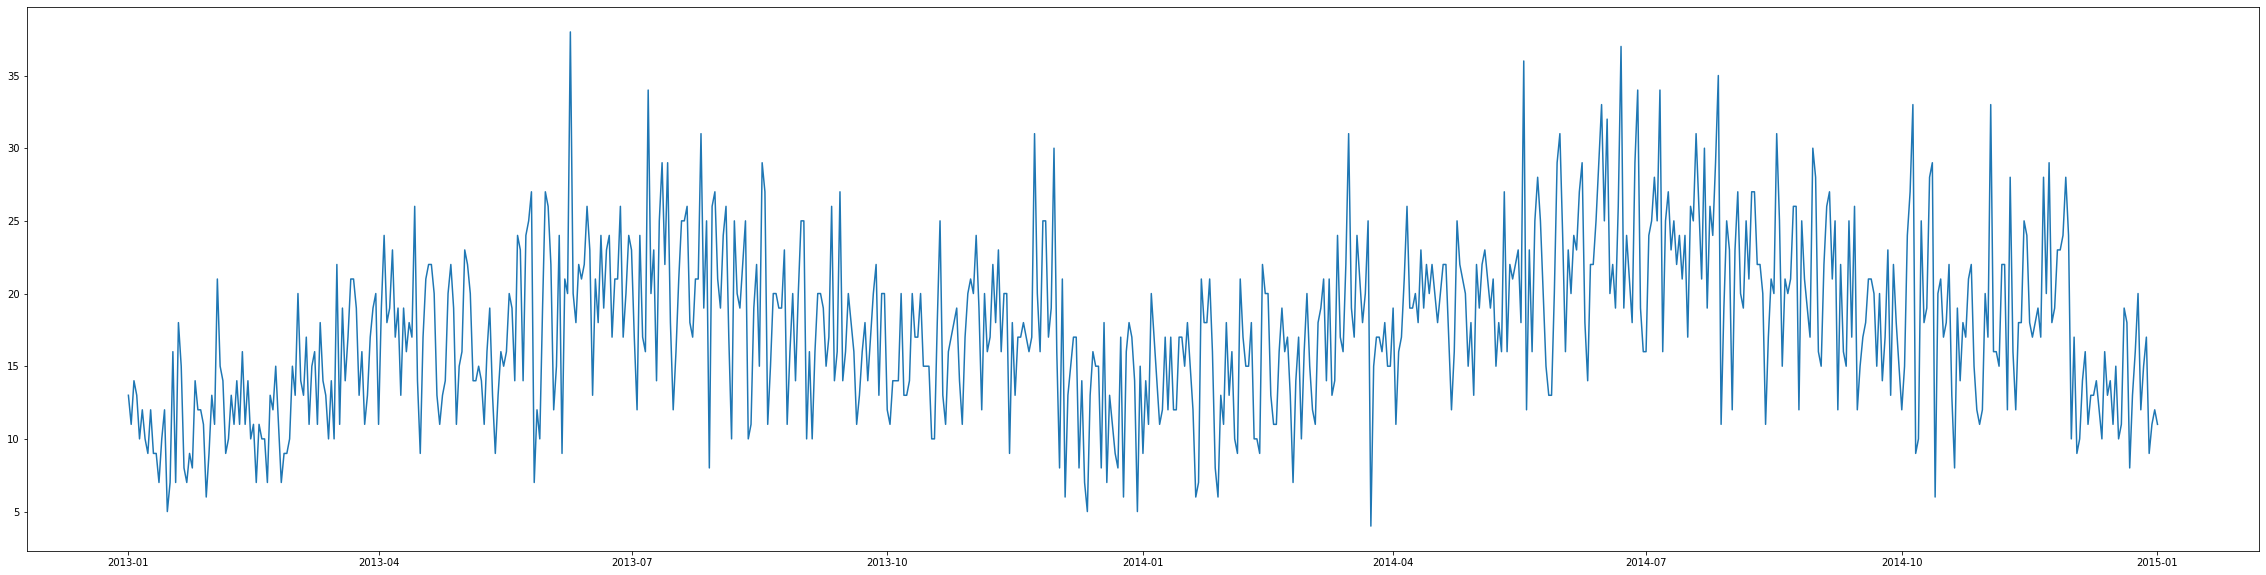

In [246]:
plt.figure(figsize=(40,10))
plt.plot(sales_datafr['date'],sales_datafr['sales'])

In [282]:
train, test = train_test_split(sales_datafr['sales'], test_size=30, shuffle=False)

In [374]:
class HoltW:
   def __init__(self, series, alpha, beta, gamma, slen, eps=1e-6):
        #Коэффициенты модели
        self.series = series
        self.train_preds = []
        self.alpha = alpha
        self.b = []
        self.beta = beta
        self.gamma = gamma
        self.slen = slen
        self.eps = eps
        self.a = []
        self.f = []
        self.coefs()
    #Вычисление параметров сглаживания
   def coefs(self):
        lin = LinearRegression()
        lin.fit(np.array(list(range(len(self.series)))).reshape(-1, 1), self.series)
        self.a.append(lin.coef_[0])
        self.b.append(lin.intercept_)
        y_lin = np.array([self.a[0] * x + self.b[0] for x in range(len(self.series))])
        for i in range(self.slen):
            y_real_i = self.series[list(range(i, len(self.series), self.slen))]
            y_lin_i = y_lin[list(range(i, len(self.series), self.slen))]
            self.f.append((y_real_i / (y_lin_i + self.eps)).mean())
   def fiting(self):
        for i in range(1, len(self.series)):
            self.b.append(self.alpha * self.series[i] / (self.f[i - 1] + self.eps) + (1 - self.alpha) * (self.b[i - 1] + self.a[i - 1]))
            self.a.append(self.beta * (self.b[i] - self.b[i - 1]) + (1 - self.beta) * self.a[i - 1])
            self.f.append(self.gamma * self.series[i] / (self.b[i] + self.eps) + (1 - self.gamma) * self.f[i - 1])
  #Функция прогноза
   def pred(self):
        preds = []
        b = self.b[:]
        a = self.a[:]
        f = self.f[:]
        for i in range(len(self.series), len(self.series) + self.slen):
            preds.append(((i + 1) * a[-1] + b[-1]) * f[-self.slen + i - len(self.series)])
        return np.array(preds)

In [373]:
model = HoltW(train, 0.0009, 0.75, 0.33, 30)
model.fiting()
preds = model.pred()

TypeError: ignored

In [321]:
preds

array([13.98967657, 14.61707064, 10.82523503, 13.08480725, 14.32439354,
       11.25322835, 15.14371913, 13.4878244 , 13.09494537, 11.08851809,
       13.49354077, 15.27957865, 14.44988592, 13.3041739 , 12.82563542,
       12.60906928, 12.58069714, 12.97317574, 15.44435987, 14.06028085,
       15.24374937, 14.10451127, 14.40051419, 13.50490861, 14.04951336,
       14.17933288, 14.85118608, 14.79061967, 10.71084495, 16.4335923 ])

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


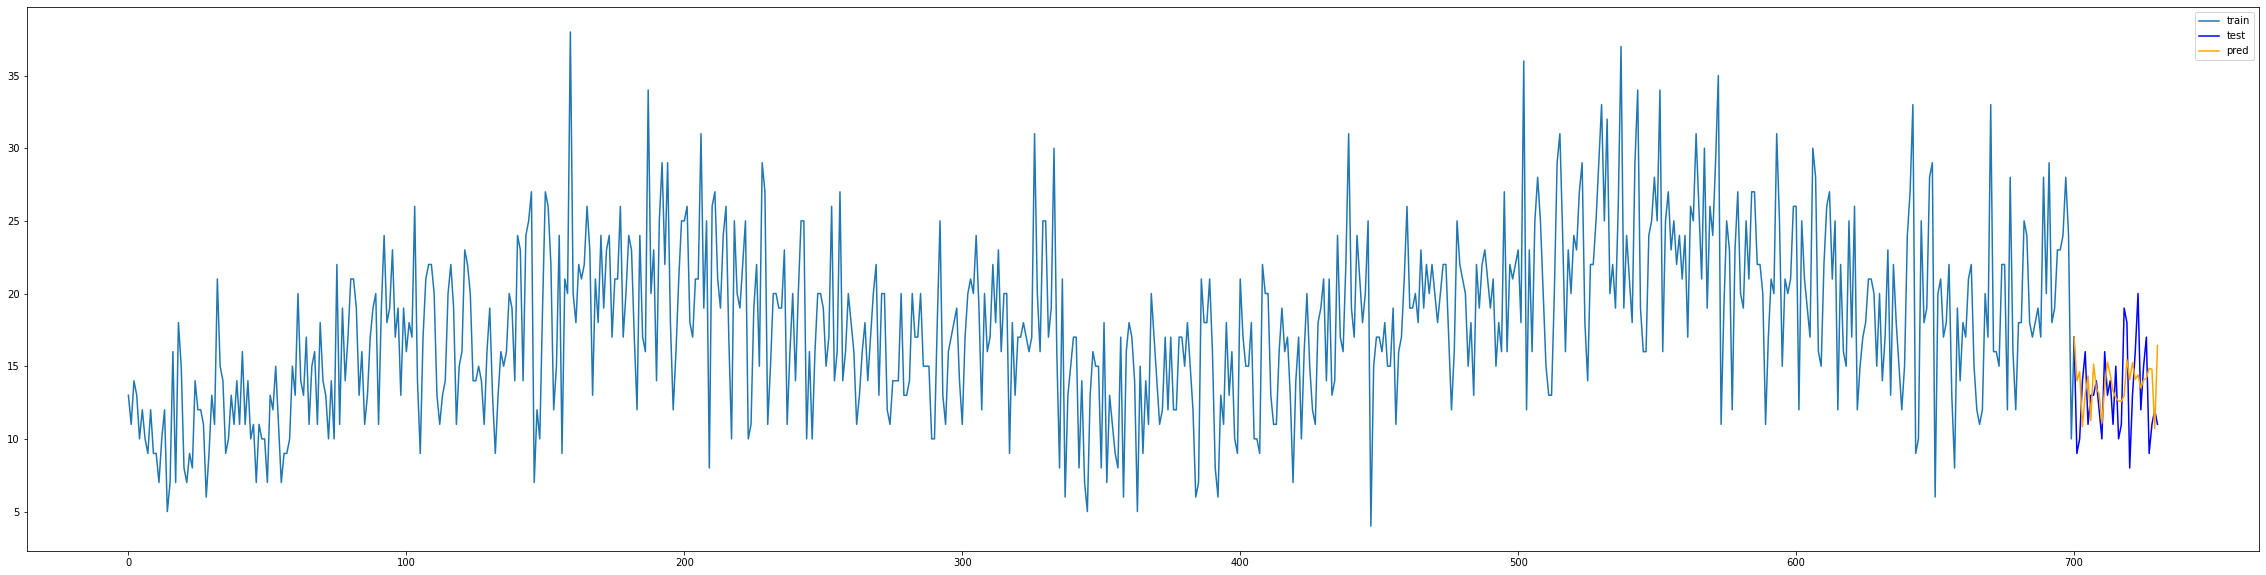

In [369]:
plt.figure(figsize=(40,10))

plt.plot(list(range(len(train))), train)
plt.plot(list(range(len(train) - 1, len(train) + len(test))), [train.tail(1), *test], color='blue')
plt.plot(list(range(len(train) - 1, len(train) + len(test))), [train.tail(1), *preds], color='orange')
plt.legend(['train', 'test', 'pred'])

##Критерий Дурбина-Уотсона

In [323]:
def durbinWatson(true, pred):
    return (((true[1:] - pred[1:]) - (true[:-1] - pred[:-1])) ** 2).sum() / ((true - pred) ** 2).sum()
print( durbinWatson(test.values, preds))

1.9441412505432543


##Количество поворотных точек

In [324]:
k = 0
res = np.abs(test.values - preds)
for i in range(1, len(res) - 1):
    if res[i] > res[i - 1] and res[i] > res[i + 1]:
        k += 1
    if res[i] < res[i - 1] and res[i] < res[i + 1]:
        k += 1

In [325]:
print('точек:', k)


точек: 21


##Проверка условия неравенства с поворотными точками



In [331]:
n = len(res)
flag = (k > round(2/3*(n - 2) - 1.96 * np.sqrt((16*n - 29)/90)))
print('Правая часть неравенства:', round(2/3*(n - 2) - 1.96 * np.sqrt((16*n - 29)/90)))
print('Условие выполняется')

Правая часть неравенства: 14
Условие выполняется


##Среднеквадратиная и Средняя относительная ошибка

In [375]:
def rmse(true, pred, p=4):
    return np.sqrt(((pred - test) ** 2).sum() / len(pred))
def relative_error(true, pred):
    return ((pred - true) / true).mean()
print('Среднеквадратиная ошибка:', rmse(test, preds))
print('Средняя относительная ошибка :', relative_error(test, preds))

Среднеквадратиная ошибка: 3.3047343362267205
Средняя относительная ошибка : 0.09910870631957597
